In [20]:
import pandas as pd
from prophet import Prophet

# Charger le fichier Excel
df = pd.read_excel("/Users/ethan/Desktop/Projet LIONEL/Taux chomage/base de donnée/base_tx_chomage.xlsx",sheet_name="Feuil2")
# Pays à traiter

df['Time period'] = pd.to_datetime(df['Time period'], errors='coerce')
df = df.dropna(subset=['Time period']).set_index('Time period')



/var/folders/gm/fq4gxj5n2zq5r3cp7wf4qzk80000gn/T/ipykernel_945/3942875943.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Time period'] = pd.to_datetime(df['Time period'], errors='coerce')


In [40]:
# Convertir la colonne date avec détection automatique
df['Time period'] = pd.to_datetime(df['Time period'], errors='coerce')
df = df.dropna(subset=['Time period'])  # Supprime les lignes sans date
df.set_index('Time period', inplace=True)

# Liste des pays à traiter
hybrid_countries = ['France', 'United Kingdom', 'Germany', 'Italy',"Spain"]

# DataFrames de sortie
residuals_df = pd.DataFrame(index=df.index)
yhat_df = pd.DataFrame(index=df.index)

# Entraînement Prophet pour chaque pays
for country in hybrid_countries:
    df_prophet = df[[country]].copy().reset_index()
    df_prophet.columns = ['ds', 'y']

    # Vérifier qu'il n'y a pas de NaN dans y
    df_prophet = df_prophet.dropna()

    try:
        model = Prophet()
        model.fit(df_prophet)

        forecast = model.predict(df_prophet[['ds']])
        yhat_df[country] = forecast['yhat'].values
        residuals_df[country] = df_prophet['y'].values - forecast['yhat'].values

    except Exception as e:
        print(f"⚠️ Erreur pour {country} : {e}")

# Affichage des 5 premières lignes des résidus
print(residuals_df.head())

/var/folders/gm/fq4gxj5n2zq5r3cp7wf4qzk80000gn/T/ipykernel_12600/3683231960.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Time period'] = pd.to_datetime(df['Time period'], errors='coerce')
10:14:12 - cmdstanpy - INFO - Chain [1] start processing
10:14:12 - cmdstanpy - INFO - Chain [1] done processing
10:14:12 - cmdstanpy - INFO - Chain [1] start processing
10:14:12 - cmdstanpy - INFO - Chain [1] done processing
10:14:13 - cmdstanpy - INFO - Chain [1] start processing
10:14:13 - cmdstanpy - INFO - Chain [1] done processing
10:14:13 - cmdstanpy - INFO - Chain [1] start processing
10:14:13 - cmdstanpy - INFO - Chain [1] done processing
10:14:13 - cmdstanpy - INFO - Chain [1] start processing
10:14:13 - cmdstanpy - INFO - Chain [1] done processing


               France  United Kingdom   Germany     Italy     Spain
Time period                                                        
1991-01-01  -0.497467       -1.425598 -0.089684  0.420510 -0.013629
1991-02-01  -0.427926       -1.263710 -0.172349  0.281081 -0.129007
1991-03-01  -0.558298       -0.932455 -0.218223  0.143337 -0.594226
1991-04-01  -0.473011       -0.723125 -0.246514  0.066247 -0.425608
1991-05-01  -0.508414       -0.574209 -0.265508 -0.010594 -0.390258


In [13]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense

# --- Chargement des résidus Prophet ---
features = ['France', 'United Kingdom', 'Germany', 'Italy']
residuals_df = residuals_df[features].dropna()
residual_data = residuals_df.values

# --- Paramètres ---
input_window = 12
output_window = 12

# --- Séquences ---
def create_sequences(data, input_len, output_len):
    X, Y = [], []
    for i in range(len(data) - input_len - output_len + 1):
        X.append(data[i:i+input_len])
        Y.append(data[i+input_len:i+input_len+output_len])
    return np.array(X), np.array(Y)

X, Y = create_sequences(residual_data, input_window, output_window)

# --- Normalisation ---
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X.reshape(-1, len(features))).reshape(X.shape)
Y_scaled = scaler.transform(Y.reshape(-1, len(features))).reshape(Y.shape)

# --- Split ---
X_train, X_val, Y_train, Y_val = train_test_split(X_scaled, Y_scaled, test_size=0.2, shuffle=False)

# --- Modèle ---
input_layer = Input(shape=(input_window, len(features)))
x = LSTM(64, return_sequences=False)(input_layer)
x = RepeatVector(output_window)(x)
x = LSTM(64, return_sequences=True)(x)
output = TimeDistributed(Dense(len(features)))(x)

model = Model(inputs=input_layer, outputs=output)
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, Y_train, epochs=50, batch_size=32, validation_data=(X_val, Y_val), verbose=1)

# --- Prédiction ---
Y_pred = model.predict(X_val)
Y_pred_rescaled = scaler.inverse_transform(Y_pred.reshape(-1, len(features))).reshape(Y_pred.shape)
Y_val_rescaled = scaler.inverse_transform(Y_val.reshape(-1, len(features))).reshape(Y_val.shape)

# --- Sauvegarde optionnelle ---
np.save("Y_pred_rescaled.npy", Y_pred_rescaled)
np.save("Y_val_rescaled.npy", Y_val_rescaled)


Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 0.2407 - val_loss: 0.1076
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0767 - val_loss: 0.0721
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0567 - val_loss: 0.0570
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0409 - val_loss: 0.0511
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0366 - val_loss: 0.0452
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0309 - val_loss: 0.0424
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0281 - val_loss: 0.0441
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0266 - val_loss: 0.0397
Epoch 9/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0271 - val_loss: 0.0390
Epoch 10/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0249 - val_loss: 0.0376
Epoch 11/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0230 - val_loss: 0.0368
Epoch 12/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0

In [14]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import pandas as pd

features = ['France', 'United Kingdom', 'Germany', 'Italy']
metrics = []

for i, country in enumerate(features):
    y_true = Y_val_rescaled[:, :, i].flatten()
    y_pred = Y_pred_rescaled[:, :, i].flatten()

    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / np.clip(np.abs(y_true), 1e-8, None))) * 100

    metrics.append({
        "Pays": country,
        "RMSE": round(rmse, 3),
        "MAE": round(mae, 3),
        "MAPE (%)": round(mape, 2)
    })

# Résultat en DataFrame
df_metrics = pd.DataFrame(metrics)
print(df_metrics)


             Pays   RMSE    MAE  MAPE (%)
0          France  0.483  0.340    360.03
1  United Kingdom  0.327  0.235    262.44
2         Germany  0.264  0.193    242.15
3           Italy  0.579  0.406    196.80


In [17]:
import matplotlib.pyplot as plt

# Supposons que tu as : Y_val_rescaled, Y_pred_rescaled (résidus), yhat_df

# Indexer les prédictions Prophet (historique)
n_seq, n_horizon, n_countries = Y_val_rescaled.shape
yhat_recent = yhat_df[features].values[-(n_seq * n_horizon):]
prophet_preds = yhat_recent.reshape((n_seq, n_horizon, n_countries))


# Reconstruction : y_final = Prophet + résidu prédit par LSTM
final_preds = prophet_preds + Y_pred_rescaled

# Afficher n séquences (chaque séquence = 12 mois pour 4 pays)
n_to_plot = 3

for i in range(n_to_plot):
    plt.figure(figsize=(12, 4))
    for j, country in enumerate(features):
        time = np.arange(output_window)
        y_true = Y_val_rescaled[i, :, j]
        y_pred = final_preds[i, :, j]

        plt.plot(time, y_true, label=f"{country} - Réel", linestyle='-')
        plt.plot(time, y_pred, label=f"{country} - Prédit", linestyle='--')

    plt.title(f"Prédiction hybride Prophet + LSTM — Séquence {i+1}")
    plt.xlabel("Mois")
    plt.ylabel("Taux de chômage (%)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


ValueError: cannot reshape array of size 1644 into shape (78,12,4)

In [18]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense
from prophet import Prophet
import matplotlib.pyplot as plt

# === 1. Charger les données ===
df = pd.read_excel("/Users/ethan/Desktop/Projet LIONEL/Taux chomage/base de donnée/base_tx_chomage.xlsx",sheet_name="Feuil2")

df['Time period'] = pd.to_datetime(df['Time period'], errors='coerce')
df = df.dropna(subset=['Time period']).set_index('Time period')
features = ['France', 'United Kingdom', 'Germany', 'Italy']
df = df[features].dropna()

# === 2. Entraîner Prophet pour chaque pays et obtenir les résidus ===
residuals_df = pd.DataFrame(index=df.index)
yhat_df = pd.DataFrame(index=df.index)

for country in features:
    df_prophet = df[[country]].reset_index()
    df_prophet.columns = ['ds', 'y']
    model = Prophet()
    model.fit(df_prophet)
    forecast = model.predict(df_prophet[['ds']])
    forecast = forecast.set_index('ds').reindex(df_prophet['ds'])
    yhat_df[country] = forecast['yhat'].values
    residuals_df[country] = df_prophet['y'].values - forecast['yhat'].values

# === 3. Préparer les séquences pour LSTM ===
input_window = 12
output_window = 12
residual_data = residuals_df.dropna().values

def create_sequences(data, input_len, output_len):
    X, Y = [], []
    for i in range(len(data) - input_len - output_len + 1):
        X.append(data[i:i+input_len])
        Y.append(data[i+input_len:i+input_len+output_window])
    return np.array(X), np.array(Y)

X, Y = create_sequences(residual_data, input_window, output_window)

# === 4. Normalisation ===
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X.reshape(-1, len(features))).reshape(X.shape)
Y_scaled = scaler.transform(Y.reshape(-1, len(features))).reshape(Y.shape)

# === 5. Split train/test ===
X_train, X_val, Y_train, Y_val = train_test_split(X_scaled, Y_scaled, test_size=0.2, shuffle=False)

# === 6. LSTM Encoder-Decoder ===
input_layer = Input(shape=(input_window, len(features)))
x = LSTM(64, return_sequences=False)(input_layer)
x = RepeatVector(output_window)(x)
x = LSTM(64, return_sequences=True)(x)
output = TimeDistributed(Dense(len(features)))(x)
model = Model(inputs=input_layer, outputs=output)
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, Y_train, epochs=50, batch_size=32, validation_data=(X_val, Y_val), verbose=0)

# === 7. Prédictions et inverse normalisation ===
Y_pred = model.predict(X_val)
Y_pred_rescaled = scaler.inverse_transform(Y_pred.reshape(-1, len(features))).reshape(Y_pred.shape)
Y_val_rescaled = scaler.inverse_transform(Y_val.reshape(-1, len(features))).reshape(Y_val.shape)

# === 8. Reconstruction finale : yhat + résidus LSTM ===
n_seq, n_horizon, n_countries = Y_val_rescaled.shape
yhat_recent = yhat_df[features].values[-(n_seq * n_horizon):]
prophet_preds = yhat_recent.reshape((n_seq, n_horizon, n_countries))
final_preds = prophet_preds + Y_pred_rescaled

# === 9. Tracer les prédictions finales vs vraies valeurs ===
for i in range(3):  # 3 séquences à tracer
    plt.figure(figsize=(12, 4))
    for j, country in enumerate(features):
        plt.plot(np.arange(n_horizon), Y_val_rescaled[i, :, j], label=f"{country} - Réel", linestyle='-')
        plt.plot(np.arange(n_horizon), final_preds[i, :, j], label=f"{country} - Prédit", linestyle='--')
    plt.title(f"Prédiction hybride Prophet + LSTM — Séquence {i+1}")
    plt.xlabel("Mois")
    plt.ylabel("Taux de chômage (%)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()



/var/folders/gm/fq4gxj5n2zq5r3cp7wf4qzk80000gn/T/ipykernel_12600/3263112474.py:13: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Time period'] = pd.to_datetime(df['Time period'], errors='coerce')
21:45:17 - cmdstanpy - INFO - Chain [1] start processing
21:45:17 - cmdstanpy - INFO - Chain [1] done processing
21:45:17 - cmdstanpy - INFO - Chain [1] start processing
21:45:17 - cmdstanpy - INFO - Chain [1] done processing
21:45:17 - cmdstanpy - INFO - Chain [1] start processing
21:45:18 - cmdstanpy - INFO - Chain [1] done processing
21:45:18 - cmdstanpy - INFO - Chain [1] start processing
21:45:18 - cmdstanpy - INFO - Chain [1] done processing


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/stepWARNING:tensorflow:6 out of the last 9 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x17984b740> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


ValueError: cannot reshape array of size 1644 into shape (78,12,4)

In [19]:
print("yhat_df.shape =", yhat_df.shape)
print("Résidus shape =", residuals_df.shape)
print("n_seq * n_horizon =", n_seq * n_horizon)


yhat_df.shape = (411, 4)
Résidus shape = (411, 4)
n_seq * n_horizon = 936


In [20]:
# Reprendre l’index temporel des prédictions à reconstruire
start_index = len(residuals_df) - (n_seq + input_window + output_window - 1)
sequence_dates = residuals_df.index[start_index + input_window : start_index + input_window + n_seq * output_window]

# Créer une table Prophet synchronisée
prophet_preds = np.zeros((n_seq, output_window, len(features)))

for i, country in enumerate(features):
    df_prophet = df[[country]].dropna().reset_index()
    df_prophet.columns = ['ds', 'y']

    model = Prophet()
    model.fit(df_prophet)

    # Faire prédire tous les mois jusqu'à la fin de la série
    full_forecast = model.predict(df_prophet[['ds']])
    full_forecast = full_forecast.set_index('ds')

    # Extraire les valeurs pour les dates exactes des séquences
    needed_dates = sequence_dates[-(n_seq * output_window):]
    values = full_forecast.loc[needed_dates, 'yhat'].values
    prophet_preds = values.reshape(n_seq, output_window, len(features))  # même shape que LSTM


21:46:52 - cmdstanpy - INFO - Chain [1] start processing
21:46:52 - cmdstanpy - INFO - Chain [1] done processing


ValueError: cannot reshape array of size 89 into shape (78,12,4)

In [28]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense
from prophet import Prophet
import matplotlib.pyplot as plt
df = pd.read_excel("/Users/ethan/Desktop/Projet LIONEL/Taux chomage/base de donnée/base_tx_chomage.xlsx",sheet_name="Feuil2")
df['Time period'] = pd.to_datetime(df['Time period'], format="%Y-%b", errors='coerce')

df['Time period'] = pd.to_datetime(df['Time period'], errors='coerce')
df = df.dropna(subset=['Time period']).set_index('Time period')
features = ['France', 'United Kingdom', 'Germany', 'Italy']
df = df[features].dropna()

# === 2. Entraîner Prophet pour chaque pays et obtenir les résidus ===
residuals_df = pd.DataFrame(index=df.index)
yhat_df = pd.DataFrame(index=df.index)

for country in features:
    df_prophet = df[[country]].reset_index()
    df_prophet.columns = ['ds', 'y']
    model = Prophet()
    model.fit(df_prophet)
    forecast = model.predict(df_prophet[['ds']])
    forecast = forecast.set_index('ds').reindex(df_prophet['ds'])
    yhat_df[country] = forecast['yhat'].values
    residuals_df[country] = df_prophet['y'].values - forecast['yhat'].values

# === 3. Préparer les séquences pour LSTM ===
input_window = 12
output_window = 12
residual_data = residuals_df.dropna().values

def create_sequences(data, input_len, output_len):
    X, Y = [], []
    for i in range(len(data) - input_len - output_len + 1):
        X.append(data[i:i+input_len])
        Y.append(data[i+input_len:i+input_len+output_window])
    return np.array(X), np.array(Y)

X, Y = create_sequences(residual_data, input_window, output_window)

# === 4. Normalisation ===
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X.reshape(-1, len(features))).reshape(X.shape)
Y_scaled = scaler.transform(Y.reshape(-1, len(features))).reshape(Y.shape)

# === 5. Split train/test ===
X_train, X_val, Y_train, Y_val = train_test_split(X_scaled, Y_scaled, test_size=0.2, shuffle=False)

# === 6. LSTM Encoder-Decoder ===
input_layer = Input(shape=(input_window, len(features)))
x = LSTM(64, return_sequences=False)(input_layer)
x = RepeatVector(output_window)(x)
x = LSTM(64, return_sequences=True)(x)
output = TimeDistributed(Dense(len(features)))(x)
model = Model(inputs=input_layer, outputs=output)
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, Y_train, epochs=50, batch_size=32, validation_data=(X_val, Y_val), verbose=0)

# === 7. Prédictions et inverse normalisation ===
Y_pred = model.predict(X_val)
Y_pred_rescaled = scaler.inverse_transform(Y_pred.reshape(-1, len(features))).reshape(Y_pred.shape)
Y_val_rescaled = scaler.inverse_transform(Y_val.reshape(-1, len(features))).reshape(Y_val.shape)

# === 8. Recalculer Prophet avec make_future_dataframe ===
n_seq, n_horizon, n_countries = Y_val_rescaled.shape
prophet_preds = np.zeros((n_seq, output_window, len(features)))

for i, country in enumerate(features):
    df_prophet = df[[country]].dropna().reset_index()
    df_prophet.columns = ['ds', 'y']
    model = Prophet()
    model.fit(df_prophet)

    # Générer assez de périodes pour couvrir toute la prédiction
    future = model.make_future_dataframe(periods=n_seq * output_window, freq='MS')
    forecast = model.predict(future)
    forecast = forecast.set_index('ds')
    values = forecast['yhat'].values[-(n_seq * output_window):]
    prophet_preds[:, :, i] = values.reshape(n_seq, output_window)

# === 9. Reconstruction finale et affichage ===
final_preds = prophet_preds + Y_pred_rescaled

# 1. Étendre les résidus avec ceux prédits
residuals_pred = Y_pred_rescaled.reshape(-1, len(features))
residuals_pred_df = pd.DataFrame(residuals_pred, columns=features)

# Créer l’index temporel pour les résidus prédits
n_pred_months = residuals_pred_df.shape[0]
pred_start_index = residuals_df.index[-n_pred_months:]
residuals_pred_df.index = residuals_df.index[-n_pred_months:]  # ✅ 936 dates


# Fusion des résidus : historique + prédits
residuals_full = pd.concat([
    residuals_df.iloc[:-n_pred_months],
    residuals_pred_df
])

# 2. Ajouter à yhat pour reconstituer les prédictions finales hybrides
final_full_pred = yhat_df[features] + residuals_full

# 3. Affichage sur toute la période
for country in features:
    plt.figure(figsize=(12, 4))
    plt.plot(df.index, df[country], label='Valeur réelle', linestyle='-')
    plt.plot(final_full_pred.index, final_full_pred[country], label='Prédiction hybride', linestyle='--')
    plt.title(f"Taux de chômage — {country} — Réel vs Prédiction (toute la période)")
    plt.xlabel("Date")
    plt.ylabel("Taux de chômage (%)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()




21:53:17 - cmdstanpy - INFO - Chain [1] start processing
21:53:17 - cmdstanpy - INFO - Chain [1] done processing
21:53:17 - cmdstanpy - INFO - Chain [1] start processing
21:53:17 - cmdstanpy - INFO - Chain [1] done processing
21:53:17 - cmdstanpy - INFO - Chain [1] start processing
21:53:18 - cmdstanpy - INFO - Chain [1] done processing
21:53:18 - cmdstanpy - INFO - Chain [1] start processing
21:53:18 - cmdstanpy - INFO - Chain [1] done processing


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step


21:53:27 - cmdstanpy - INFO - Chain [1] start processing
21:53:27 - cmdstanpy - INFO - Chain [1] done processing
21:53:28 - cmdstanpy - INFO - Chain [1] start processing
21:53:28 - cmdstanpy - INFO - Chain [1] done processing
21:53:28 - cmdstanpy - INFO - Chain [1] start processing
21:53:28 - cmdstanpy - INFO - Chain [1] done processing
21:53:28 - cmdstanpy - INFO - Chain [1] start processing
21:53:28 - cmdstanpy - INFO - Chain [1] done processing


ValueError: Length mismatch: Expected axis has 936 elements, new values have 411 elements

21:13:10 - cmdstanpy - INFO - Chain [1] start processing
21:13:10 - cmdstanpy - INFO - Chain [1] done processing
21:13:10 - cmdstanpy - INFO - Chain [1] start processing
21:13:10 - cmdstanpy - INFO - Chain [1] done processing
21:13:10 - cmdstanpy - INFO - Chain [1] start processing
21:13:10 - cmdstanpy - INFO - Chain [1] done processing
21:13:10 - cmdstanpy - INFO - Chain [1] start processing
21:13:10 - cmdstanpy - INFO - Chain [1] done processing
21:13:11 - cmdstanpy - INFO - Chain [1] start processing
21:13:11 - cmdstanpy - INFO - Chain [1] done processing
21:13:11 - cmdstanpy - INFO - Chain [1] start processing
21:13:11 - cmdstanpy - INFO - Chain [1] done processing


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


21:13:16 - cmdstanpy - INFO - Chain [1] start processing
21:13:16 - cmdstanpy - INFO - Chain [1] done processing
21:13:16 - cmdstanpy - INFO - Chain [1] start processing
21:13:16 - cmdstanpy - INFO - Chain [1] done processing
21:13:16 - cmdstanpy - INFO - Chain [1] start processing
21:13:16 - cmdstanpy - INFO - Chain [1] done processing
21:13:16 - cmdstanpy - INFO - Chain [1] start processing
21:13:16 - cmdstanpy - INFO - Chain [1] done processing
21:13:16 - cmdstanpy - INFO - Chain [1] start processing
21:13:16 - cmdstanpy - INFO - Chain [1] done processing
21:13:16 - cmdstanpy - INFO - Chain [1] start processing
21:13:16 - cmdstanpy - INFO - Chain [1] done processing


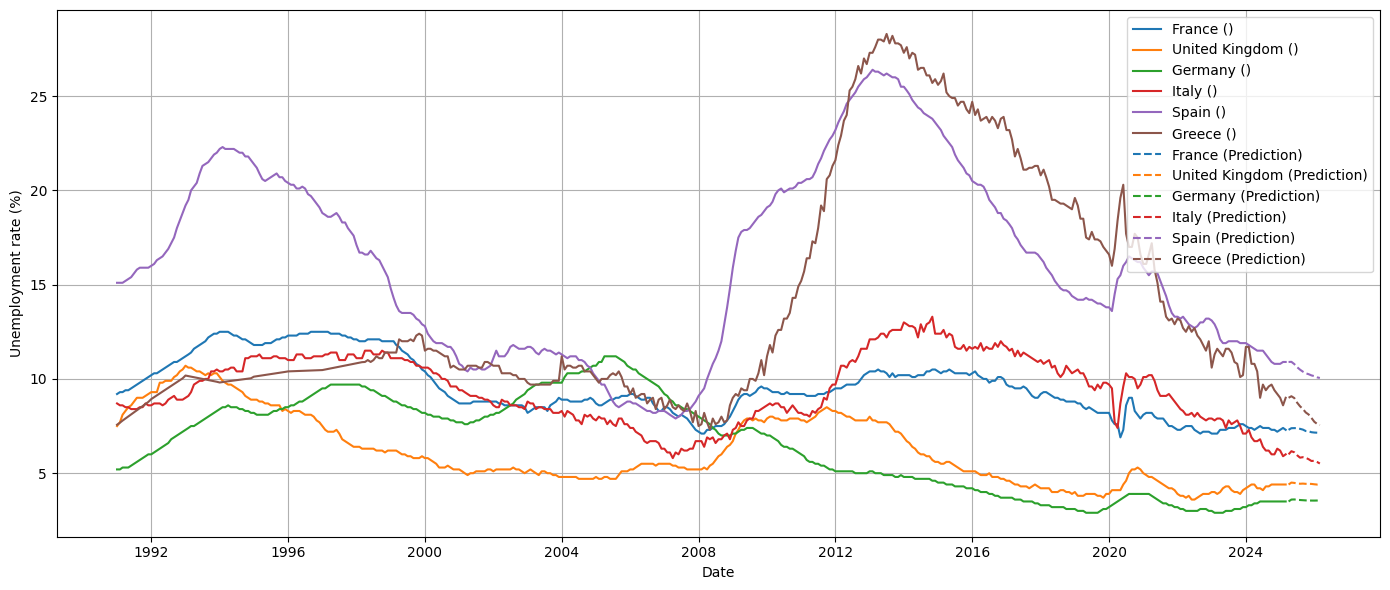

,France,United Kingdom,Germany,Italy,Spain,Greece
ds,,,,,,
2025-04-01,7.300000,4.400000,3.500000,6.000000,10.900000,9.000000
2025-05-01,7.386947,4.502477,3.601000,6.166058,10.907896,9.082141
2025-06-01,7.390683,4.484347,3.607092,6.108217,10.788847,8.985388
2025-07-01,7.391617,4.452996,3.586741,5.952983,10.625387,8.743226
2025-08-01,7.352932,4.440099,3.577434,5.823812,10.493105,8.550319
2025-09-01,7.312014,4.447656,3.566718,5.848918,10.386083,8.405847
2025-10-01,7.237397,4.435675,3.556777,5.816107,10.298773,8.222880
2025-11-01,7.222670,4.436518,3.549967,5.742006,10.251777,8.112649
2025-12-01,7.174060,4.430489,3.548094,5.648299,10.188081,7.933661


In [28]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense
from tensorflow.keras.optimizers import Adam
from prophet import Prophet
import matplotlib.pyplot as plt
import random
random.seed(42)

# === 1. Charger les données ===
features = ['France', 'United Kingdom', 'Germany', 'Italy', "Spain","Greece"]
df = df[features].dropna()

# === 2. Entraîner Prophet et calculer les résidus ===
residuals_df = pd.DataFrame(index=df.index)
yhat_df = pd.DataFrame(index=df.index)

for country in features:
    df_prophet = df[[country]].reset_index()
    df_prophet.columns = ['ds', 'y']
    model_p = Prophet()
    model_p.fit(df_prophet)
    forecast = model_p.predict(df_prophet[['ds']])
    forecast = forecast.set_index('ds').reindex(df_prophet['ds'])
    yhat_df[country] = forecast['yhat'].values
    residuals_df[country] = df_prophet['y'].values - forecast['yhat'].values

# === 3. Construire les séquences LSTM ===
input_window = 12
output_window = 12

def create_sequences(data, input_len, output_len):
    X, Y = [], []
    for i in range(len(data) - input_len - output_len + 1):
        X.append(data[i:i+input_len])
        Y.append(data[i+input_len:i+input_len+output_window])
    return np.array(X), np.array(Y)

X, Y = create_sequences(residuals_df.values, input_window, output_window)

# === 4. Normalisation ===
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X.reshape(-1, len(features))).reshape(X.shape)
Y_scaled = scaler.transform(Y.reshape(-1, len(features))).reshape(Y.shape)

# === 5. Entraînement du modèle avec hyperparamètres optimisés ===
best_params = {
    'lstm_units': 59,
    'dropout': 0.31155916145855805,
    'lr': 0.00022703104800371975,
    'batch_size': 32,
    'num_layers': 1,
    'recurrent_dropout': 0.0,      # Si tu veux utiliser un `recurrent_dropout`
    'activation': 'tanh'           # Ajouté ici au cas où tu veux tester différents
}

input_layer = Input(shape=(input_window, len(features)))
x = input_layer
for _ in range(best_params['num_layers']):
    x = LSTM(
        best_params['lstm_units'],
        return_sequences=False,
        activation=best_params.get('activation', 'tanh'),
        recurrent_dropout=best_params.get('recurrent_dropout', 0.0)
    )(x)
    x = RepeatVector(output_window)(x)

x = LSTM(
    best_params['lstm_units'],
    return_sequences=True,
    dropout=best_params['dropout'],
    activation=best_params.get('activation', 'tanh')
)(x)

output = TimeDistributed(Dense(len(features)))(x)
model = Model(inputs=input_layer, outputs=output)
optimizer = Adam(learning_rate=best_params['lr'])
model.compile(optimizer=optimizer, loss='mse')
model.fit(X_scaled, Y_scaled, epochs=50, batch_size=best_params['batch_size'], verbose=0)

# === 6. Prédiction sur les 12 mois à venir ===
X_input = residuals_df.values[-input_window:].reshape(1, input_window, len(features))
X_input_scaled = scaler.transform(X_input.reshape(-1, len(features))).reshape(X_input.shape)
Y_future_pred_scaled = model.predict(X_input_scaled)
Y_future_pred = scaler.inverse_transform(Y_future_pred_scaled.reshape(-1, len(features)))

# === 7. Générer Prophet sur 12 mois futurs et combiner ===
future_preds = {}
future_dates = None

for i, country in enumerate(features):
    df_country = df[[country]].reset_index()
    df_country.columns = ['ds', 'y']
    m = Prophet()
    m.fit(df_country)
    future = m.make_future_dataframe(periods=12, freq='MS')
    forecast = m.predict(future)
    yhat_future = forecast.set_index('ds').iloc[-12:]['yhat'].values
       # Ajouter les résidus
    pred = yhat_future + Y_future_pred[:, i]

    # Recaler pour continuité : faire commencer la prévision à la dernière valeur réelle
    last_real_value = df[country].iloc[-1]
    offset = last_real_value - pred[0]
    final_pred = pred + offset
    future_preds[country] = final_pred
    if future_dates is None:
        future_dates = forecast.set_index('ds').iloc[-12:].index

# === 8. Affichage des résultats ===
future_df = pd.DataFrame(future_preds, index=future_dates)

# === 8. Affichage de toutes les prévisions sur un seul graphique ===
plt.figure(figsize=(14, 6))

# Dictionnaire pour stocker les couleurs assignées
color_map = {}

# Tracer les courbes historiques et enregistrer les couleurs
for country in features:
    line, = plt.plot(df[country], label=f"{country} ()", linestyle='-')
    color_map[country] = line.get_color()

# Tracer les prédictions futures avec les mêmes couleurs
for country in features:
    plt.plot(future_df[country], label=f"{country} (Prediction)", linestyle='--', color=color_map[country])

plt.xlabel("Date")
plt.ylabel("Unemployment rate (%)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


future_df


In [22]:
import optuna
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense
import numpy as np

# === Séparer les données en training et validation ===
X_train, X_val, Y_train, Y_val = train_test_split(X_scaled, Y_scaled, test_size=0.2, shuffle=False)

# === Fonction objectif Optuna ===
def objective(trial):
    # Espace de recherche étendu
    lstm_units = trial.suggest_int("lstm_units", 32, 256)
    dropout = trial.suggest_float("dropout", 0.0, 0.5)
    recurrent_dropout = trial.suggest_float("recurrent_dropout", 0.0, 0.5)
    lr = trial.suggest_float("lr", 1e-5, 1e-2, log=True)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64, 128])
    num_layers = trial.suggest_int("num_layers", 1, 3)
    activation = trial.suggest_categorical("activation", ["tanh", "relu"])
    optimizer_name = trial.suggest_categorical("optimizer", ["adam", "rmsprop", "nadam"])

    # === Construction du modèle ===
    input_layer = Input(shape=(input_window, len(features)))
    x = input_layer
    for _ in range(num_layers):
        x = LSTM(lstm_units, return_sequences=False, activation=activation, recurrent_dropout=recurrent_dropout)(x)
        x = RepeatVector(output_window)(x)
    x = LSTM(lstm_units, return_sequences=True, dropout=dropout, activation=activation)(x)
    output = TimeDistributed(Dense(len(features)))(x)

    model = Model(inputs=input_layer, outputs=output)

    # Optimiseur
    if optimizer_name == "adam":
        optimizer = Adam(learning_rate=lr)
    elif optimizer_name == "rmsprop":
        from tensorflow.keras.optimizers import RMSprop
        optimizer = RMSprop(learning_rate=lr)
    else:
        from tensorflow.keras.optimizers import Nadam
        optimizer = Nadam(learning_rate=lr)

    model.compile(optimizer=optimizer, loss='mse')

    # Entraînement
    model.fit(X_train, Y_train, epochs=30, batch_size=batch_size, verbose=0, validation_data=(X_val, Y_val))

    # Prédiction & inverse transform
    Y_val_pred = model.predict(X_val)
    Y_val_pred_rescaled = scaler.inverse_transform(Y_val_pred.reshape(-1, len(features))).reshape(Y_val_pred.shape)
    Y_val_rescaled = scaler.inverse_transform(Y_val.reshape(-1, len(features))).reshape(Y_val.shape)

    # MAPE
    mape = np.mean(np.abs((Y_val_rescaled - Y_val_pred_rescaled) / np.clip(np.abs(Y_val_rescaled), 1e-8, None))) * 100
    return mape

# === Configuration de l'étude ===
study = optuna.create_study(
    direction="minimize",
    sampler=optuna.samplers.TPESampler(seed=42)
)

# === Lancer l'optimisation longue durée ===
study.optimize(
    objective,
    n_trials=1000,            # jusqu’à 1000 essais
    timeout=None              # pas de limite de temps
)

# === Résultat final ===
print("Meilleurs hyperparamètres trouvés :")
print(study.best_params)


[I 2025-06-08 21:03:45,051] A new study created in memory with name: no-name-cbcb09c3-4498-4bae-a172-53abc1c7a5ca


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 178ms/step


[I 2025-06-08 21:03:53,169] Trial 0 finished with value: 167.48459313631284 and parameters: {'lstm_units': 116, 'dropout': 0.4753571532049581, 'recurrent_dropout': 0.36599697090570255, 'lr': 0.0006251373574521745, 'batch_size': 128, 'num_layers': 2, 'activation': 'tanh', 'optimizer': 'adam'}. Best is trial 0 with value: 167.48459313631284.
[W 2025-06-08 21:03:53,914] Trial 1 failed with parameters: {'lstm_units': 72, 'dropout': 0.09170225492671691, 'recurrent_dropout': 0.15212112147976886, 'lr': 0.00037520558551242813, 'batch_size': 64, 'num_layers': 1, 'activation': 'relu', 'optimizer': 'adam'} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/Users/ethan/Desktop/Projet LIONEL/env/lib/python3.11/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/var/folders/gm/fq4gxj5n2zq5r3cp7wf4qzk80000gn/T/ipykernel_945/1652437508.py", line 47, in objective
    

KeyboardInterrupt: 

In [25]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Dictionnaire pour stocker les yhat Prophet (valeurs de base) pour comparaison
yhat_future_dict = {}

# Recalculer Prophet pour extraire les yhat de référence
for country in features:
    df_country = df[[country]].reset_index()
    df_country.columns = ['ds', 'y']
    m = Prophet()
    m.fit(df_country)
    future = m.make_future_dataframe(periods=12, freq='MS')
    forecast = m.predict(future)
    forecast = forecast.set_index('ds')
    yhat_future_dict[country] = forecast.iloc[-12:]['yhat'].values

# Calcul des métriques
metrics = {}

for country in features:
    y_true = yhat_future_dict[country]
    y_pred = future_df[country].values

    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / np.clip(np.abs(y_true), 1e-8, None))) * 100

    metrics[country] = {
        'RMSE': round(rmse, 3),
        'MAE': round(mae, 3),
        'MAPE (%)': round(mape, 2)
    }

metrics_df = pd.DataFrame(metrics).T
print("\n📊 MÉTRIQUES DE PRÉDICTION (comparées à Prophet seul) :")
print(metrics_df)


21:10:35 - cmdstanpy - INFO - Chain [1] start processing
21:10:35 - cmdstanpy - INFO - Chain [1] done processing
21:10:35 - cmdstanpy - INFO - Chain [1] start processing
21:10:35 - cmdstanpy - INFO - Chain [1] done processing
21:10:35 - cmdstanpy - INFO - Chain [1] start processing
21:10:35 - cmdstanpy - INFO - Chain [1] done processing
21:10:35 - cmdstanpy - INFO - Chain [1] start processing
21:10:35 - cmdstanpy - INFO - Chain [1] done processing
21:10:35 - cmdstanpy - INFO - Chain [1] start processing
21:10:35 - cmdstanpy - INFO - Chain [1] done processing
21:10:35 - cmdstanpy - INFO - Chain [1] start processing
21:10:35 - cmdstanpy - INFO - Chain [1] done processing



📊 MÉTRIQUES DE PRÉDICTION (comparées à Prophet seul) :
                 RMSE    MAE  MAPE (%)
France          0.051  0.043      0.65
United Kingdom  0.073  0.068      1.62
Germany         0.031  0.026      0.79
Italy           0.061  0.044      0.70
Spain           0.656  0.647      6.07
Greece          0.133  0.129      1.71
